In [1]:
import import_ipynb
from BackgroundCosmology import *

importing Jupyter notebook from BackgroundCosmology.ipynb


In [2]:
π = np.pi
eV = 1.60217646e-19
κ = 1.3806503e-23       # Boltzmann's constant [J / K]
ħ = 1.05457148e-34      # [J sec]

ϵ = 13.0605698*eV
#ϵ = 2.1798729e-18       # Hydrogen ionization energy [J]
G = 6.67258e-11         # [m^3 / kg sec^2]
α = 7.29735308e-3       # dimensionless

t0 = 2.725              # Temperature today [K]
σt = 6.652462e-29       # Thompson Cross-section [m^2]
mh = 1.673534e-27       # mass of proton [kg]
me = 9.10938188e-31     # mass of electron [kg]

ρc = 3.0*H0**2.0/(8.0*π*G)

In [3]:
SAHA_LIMIT = .99

xstart = np.log(1.0e-10)
xstop = np.log(1.0)
n = 1000

der = 1                 # Derivative order; used in τ and g spline derivatives

In [4]:
def dxedx(x, t):
    """This function represents Peebles's equation and is called by odeint
    to solve for the electron fraction after said fraction drops below .99."""
    
    baryon_den = Ωb*ρc/mh*np.exp(-3.0*t)
    baryon_tmp = t0/np.exp(t)
    
    X_e = x
    
    ϕ2 = .488*np.log(ϵ/(κ*baryon_tmp))
    
    α2 = 64.0*π/np.sqrt(27.0*π)*α**2.0*ħ**2/(me**2.0*c)*np.sqrt(ϵ/(κ*baryon_tmp))*ϕ2
    
    β = α2*(me*baryon_tmp*κ/(2.0*π*ħ**2.0))**(3.0/2.0)*np.exp(-ϵ/(κ*baryon_tmp))
    
    β2 = α2*(me*baryon_tmp*κ/(2.0*π*ħ**2.0))**(3.0/2.0)*np.exp(-ϵ/(4.0*κ*baryon_tmp))
    
    Λα = getH(t)*(3.0*ϵ/(ħ*c))**3.0/((8.0*π)**2.0*(1.0 - X_e)*baryon_den)
    
    Λ2 = 8.227
    
    Cr = (Λ2 + Λα)/(Λ2 + Λα + β2)
    
    return Cr*(β*(1.0 - X_e) - baryon_den*α2*X_e**2.0)/getH(t)

def dτdx(t, x):
    """This function is used for integrating the optical depth (τ) differential equation."""
    return -ne2(x)*σt*c*np.exp(x)/getHPrime(x)

def get_funct_der(x_arr, a_spl, der):
    """This function returns the n-th derivative of either the τ or g spline, whichever is passed here.
    It requires the inputs: (x-array, spline, derivative order)."""
    return splev(x_arr, a_spl, der)

In [5]:
# This section of code finds the electron fraction X_e
x_rec_grid = np.linspace(xstart, xstop, n, endpoint=True)

zrec = np.zeros(n)
for i in range(len(x_rec_grid)): zrec[i] = 1.0/np.exp(x_rec_grid[i])
    
Xe = np.zeros(n)     # Free electron fraction
ne = np.zeros(n)     # Electron density

# In this part, solve for the first value of the Xe array;
#  maybe not necessary, but it made creating the while loop easier
j = 0
baryon_den = Ωb*ρc/(mh*np.exp(3.0*x_rec_grid[j]))
baryon_tmp = t0/np.exp(x_rec_grid[j])

part1 = 1.0/baryon_den
part2 = np.sqrt(me*baryon_tmp*κ/(2.0*π*ħ**2.0))**3.0
part3 = np.exp(-ϵ/(κ*baryon_tmp))
parts = part1*part2*part3

Xe[j] = (-parts + np.sqrt(parts*(parts + 4.0)))/2.0

ne[j] = Xe[j]*baryon_den

while Xe[j] > SAHA_LIMIT:
    j += 1
    
    baryon_den = Ωb*ρc/(mh*np.exp(3.0*x_rec_grid[j]))
    baryon_tmp = t0/np.exp(x_rec_grid[j])

    part1 = 1.0/baryon_den
    part2 = (me*baryon_tmp*κ/(2.0*π*ħ**2.0))**(3.0/2.0)
    part3 = np.exp(-ϵ/(κ*baryon_tmp))
    parts = part1*part2*part3
    
    Xe[j] = (-parts + np.sqrt(parts*(parts + 4.0)))/2.0

    ne[j] = Xe[j]*baryon_den

for i in range(j, n):
    baryon_den = Ωb*ρc/(mh*np.exp(3.0*x_rec_grid[i]))
    
    temp  = odeint(dxedx, Xe[i - 1], x_rec_grid[(i - 1):i + 1])
    
    Xe[i] = temp[1]
    ne[i] = Xe[i]*baryon_den

# baryon_den: later we use '2' to represent a derivative, but here it's just a label!
ne2 = BSpline(x_rec_grid, ne, k=spline_order)

In [6]:
# Here we will compute the optical depth at all grid points

# We integrate backwards from today, so start by flipping the recombination x array
xflip = np.flipud(x_rec_grid) 
flipτ = odeint(dτdx, 0.0, xflip)

τ = np.flipud(flipτ)                 # And then flip it back to the correct way
τspl = BSpline(x_rec_grid, τ, k=spline_order)

# Compute the splined derivative of the optical depth
τ2 = get_funct_der(x_rec_grid, τspl, der)   # A '2' represents a prime; i.e. τ' = dτ/dx
τ2spl = BSpline(x_rec_grid, τ2, k=spline_order)

# Compute the splined second derivative of the optical depth
τ22 = get_funct_der(x_rec_grid, τ2spl, der)  # d2τ/dx2
τ22spl = BSpline(x_rec_grid, τ22, k=spline_order)


# Compute and spline the visibility function g
g = [-get_funct_der(x_rec_grid[i], τspl, der)*np.exp(-τspl(x_rec_grid[i])) for i in range(n)]    
gspl = BSpline(x_rec_grid, g, k=spline_order)

# Compute splined first derivative of the visibility function
g2 = get_funct_der(x_rec_grid, gspl, der=1)
g2spl = BSpline(x_rec_grid, g2, k=spline_order)

# Compute the splined second derivative of g
g22 = get_funct_der(x_rec_grid, g2spl, der=1)
g22spl = BSpline(x_rec_grid, g2, k=spline_order)

In [21]:
# Compute x_* and z_* (time of last scattering); this occurs when g is at a maximum.
# Use the index of the max value of g to get the value of x (i.e. x_*) at that index,
#  which is used to calculate z_*
x_s = x_rec_grid[g.index(max(g))]
a_s = np.exp(x_s)
z_s = (1.0/a_s) - 1.0

# Compute the half-way point of recombination; this occurs when Xe = .5
# If we take the absolute value of Xe[i] minus the value we want (.5),
#  then the lowest value of the new array will be when Xe is closest to .5
# Therefore we use this index in our x-grid to get x_rec. This is used to compute z_rec
sub_lowest = [abs(Xe[i] - .5) for i in range(n)]
lowest_index = sub_lowest.index(min(sub_lowest))
x_r = x_rec_grid[lowest_index]
a_r = np.exp(x_r)
z_r = (1.0/a_r) - 1.0

# Compute the half-way point of recombination using only the Saha equation;
#  compare it to the results of Saha + Peebles
only_saha_xe = np.zeros(n)
for i in range(n):
    baryon_den = Ωb*ρc/(mh*np.exp(3.0*x_rec_grid[i]))
    baryon_tmp = t0/np.exp(x_rec_grid[i])

    part1 = 1.0/baryon_den
    part2 = (me*baryon_tmp*κ/(2.0*π* ħ**2.0))**(3.0/2.0)
    part3 = np.exp(-ϵ/(κ*baryon_tmp))
    parts = part1*part2*part3
    
    only_saha_xe[i] = (-parts + np.sqrt(parts*(parts + 4.0)))/2.0

lowest_only_saha = [abs(only_saha_xe[i] - .5) for i in range(n)]
lowest_index_saha = lowest_only_saha.index(min(lowest_only_saha))
x_r2 = x_rec_grid[lowest_index_saha]
a_r2 = np.exp(x_r2)
z_r2 = (1.0/a_r2) - 1.0

In [8]:
print('The surface of last scattering occured at x_* = %5.2f and z_* = %5.2f.\n' %(x_s, z_s))
print('The half-way point of recombination occured at x_r = %5.2f and z_r = %5.2f.\n' %(x_r, z_r))
print('Using only the Saha equation, the half-way point of recombination occured at x_r = %5.2f and z_r = %5.2f.\n' %(x_r2, z_r2))

The surface of last scattering occured at x_* = -6.85 and z_* = 938.66.

The half-way point of recombination occured at x_r = -7.12 and z_r = 1238.06.

Using only the Saha equation, the half-way point of recombination occured at x_r = -7.19 and z_r = 1326.77.



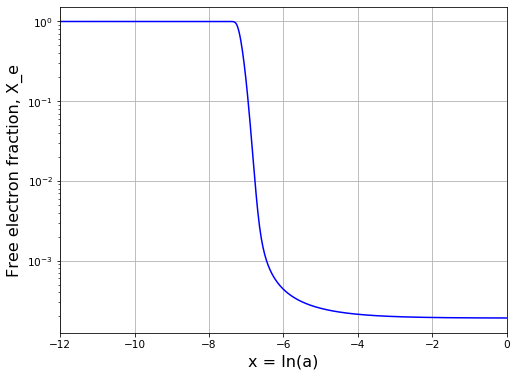

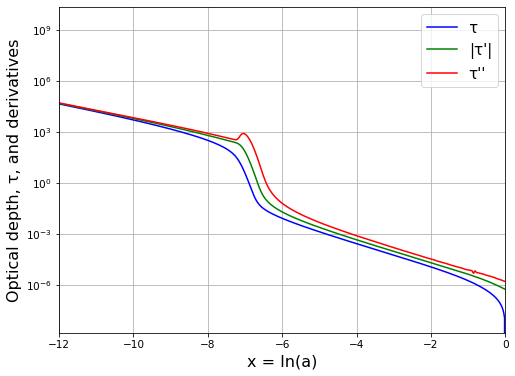

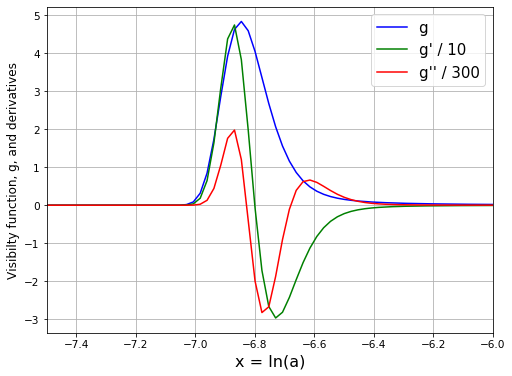

In [23]:
'''
plt.figure(figsize = (8, 6))
#plt.xlabel('z', fontsize = 16)
plt.xlabel('x = ln(a)', fontsize = 16)
plt.ylabel('Free electron fraction, X_e', fontsize = 16)
#plt.plot(zrec[zrec<1850], Xe[zrec<1850], color = 'blue')
#plt.plot(zrec[zrec<1850], only_saha_xe[zrec<1850], color = 'red')
plt.plot(x_rec_grid, Xe, color = 'blue')
plt.yscale('log')
plt.xlim(-12, 0)
#plt.ylim(1e-4, 10)
#ax = plt.gca()
#ax.invert_xaxis()
plt.grid()
#plt.savefig('electron_fraction_both')

plt.figure(figsize = (8, 6))
plt.xlabel('x = ln(a)', fontsize = 16)
plt.ylabel('Optical depth, τ, and derivatives', fontsize = 16)
plt.plot(x_rec_grid,       τ, color = 'blue',  label = 'τ')
plt.plot(x_rec_grid, abs(τ2), color = 'green', label = '|τ\'|')
plt.plot(x_rec_grid,     τ22, color = 'red',   label = 'τ\'\'')
plt.yscale('log')
plt.xlim(-12, 0)
plt.legend(prop = {'size': 15})
plt.grid()
#plt.savefig('optical_depth')

plt.figure(figsize = (8, 6))
plt.xlabel('x = ln(a)', fontsize = 16)
plt.ylabel('Visibilty function, g, and derivatives', fontsize = 12)
plt.plot(x_rec_grid, g,           color = 'blue',  label = 'g')
plt.plot(x_rec_grid, g2 / 10.0,   color = 'green', label = 'g\' / 10')
plt.plot(x_rec_grid, g22 / 300.0, color = 'red',   label = 'g\'\' / 300')
plt.xlim(-7.5, -6)
plt.legend(prop = {'size': 15})
plt.grid()
#plt.savefig('photon_scatter')
'''